In [183]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import pandas as pd
import cvxpy as cvx

In [287]:
%run numpy_nn.py

### Data

In [288]:
n_features = 10
n_samples = 800

X = np.random.randn(n_samples, n_features)

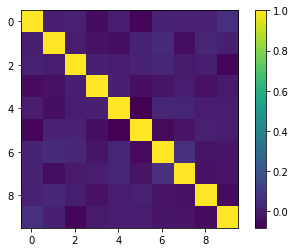

In [289]:
plt.imshow(np.corrcoef(X.T))
plt.colorbar()

In [290]:
def generate_collinear_features(n, X):
    n_features = X.shape[1]
    X_new = np.zeros([X.shape[0], n])
    for i in range(n):
        n_cols = max(2, np.random.randint(n_features / 3) + 1)
        col_idxs = np.random.choice(np.arange(n_features), int(n_cols), replace=False)
        coef = np.random.rand(n_cols)
        coef /= np.sqrt(np.sum(coef ** 2))
        X_new[:, i] = X[:, col_idxs].dot(coef) 
    return X_new

X_col = generate_collinear_features(40, X)

In [291]:
X = np.hstack([X, X_col])

n_samples, n_features = X.shape

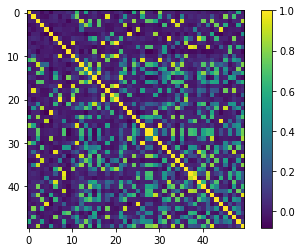

In [292]:
plt.imshow(np.corrcoef(X.T))
plt.colorbar()

In [293]:
n_hidden = 40
n_out = 2

W1_true = np.random.randn(n_hidden, n_features)
W2_true = np.random.randn(n_out, n_hidden)
b1_true = np.random.randn(n_hidden)
b2_true = np.random.randn(n_out)

mask1 = (np.random.randn(*W1_true.shape) > 0.5)
mask2 = (np.random.randn(*W2_true.shape) > 0.5)

W1_true *= mask1
W2_true *= mask2

layer1 = Linear(n_features, n_hidden, W_init=W1_true, b_init=b1_true)
layer2 = Linear(n_hidden, n_out, W_init=W2_true, b_init=b2_true)
act2 = SoftMax()
act1 = LeakyReLU(slope=0.1)

y = act2.forward(layer2.forward(act1.forward(layer1.forward(X)))) + np.random.randn(n_samples, n_out) * 0.7
y = (y > 0.5).astype(float)

In [111]:
y.mean()

0.47215143203465543

### Neural network optimization

In [294]:
def sgd_momentum(x, dx, config, state):
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, 
                   out = cur_old_grad)
            cur_x -= cur_old_grad
            
            i += 1
            
def nesterov(x, dx, config, state):
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, 
                   out = cur_old_grad)
            
            cur_x -= cur_old_grad * config['momentum'] + config['learning_rate'] * cur_dx
            i += 1
            
def adam(x, dx, config, state):
    state.setdefault('old_grad', {})
    state.setdefault('old_squared_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            cur_old_squared_grad = state['old_squared_grad'].setdefault(i, 
                                                                        np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, (1 - config['momentum']) * cur_dx, 
                   out = cur_old_grad)
            
            np.add(config['squared_momentum'] * cur_old_squared_grad, 
                   (1 - config['squared_momentum']) * cur_dx ** 2,
                   out = cur_old_squared_grad)
            
            cog = cur_old_grad / (1 - config['momentum'])
            cosg = cur_old_squared_grad / (1 - config['squared_momentum'])
            
            cur_x -= config['learning_rate'] * np.divide(cog, np.sqrt(cosg) + config['eps'])
            i += 1

In [295]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [296]:
def train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, optimizer_method, criterion,
          optimizer_config, optimizer_state, weight_decay=False):
    loss_history = []
    train_acc = []
    test_acc = []
    
    for i in range(n_epoch):
        if weight_decay and i % 10 == 0:
            optimizer_config['learning_rate'] *= 0.5
            
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights

            optimizer_method(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_history.append(loss)
        
        pred_train = net.forward(X_train).argmax(axis=1)
        train_acc.append(float(np.sum(y_train[:, 1] == pred_train)) / len(y_train))
        
        pred_test = net.forward(X_test).argmax(axis=1)
        test_acc.append(float(np.sum(y_test[:, 1] == pred_test)) / len(y_test))

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.semilogy(loss_history, 'b')
        plt.subplot(1, 2, 2)
        plt.title("Accuracy")
        plt.xlabel("#epoch")
        plt.ylabel("accuracy")
        plt.plot(train_acc, 'r', label='train')
        plt.plot(test_acc, 'g', label='test')
        plt.legend()
        plt.show()

        print('Current loss: %f' % loss)
    return loss_history, train_acc, test_acc

### Toy exampe

(1000, 2) (500, 2)


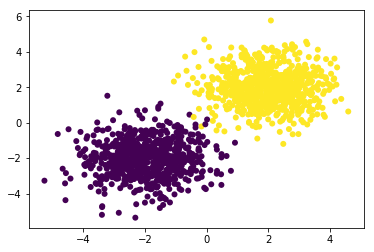

In [235]:
# Generate some data
N = 750

X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])

y_toy = np.concatenate([np.ones(N),np.zeros(N)])[:, None]
y_toy = np.hstack([y_toy, 1 - y_toy])

X_toy = np.vstack([X1, X2])
idxs = np.random.permutation(np.arange(len(y_toy)))
X_toy = X_toy[idxs]
y_toy = y_toy[idxs]

plt.scatter(X_toy[:, 0], X_toy[:, 1], c = y_toy[:, 0], edgecolors= 'none')

X_train = X_toy[:int(2 * len(y_toy) / 3), :]
y_train = y_toy[:int(2 * len(y_toy) / 3)]
X_test = X_toy[int(2 * len(y_toy) / 3):, :]
y_test = y_toy[int(2 * len(y_toy) / 3):]
print(X_train.shape, X_test.shape)

In [236]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear(2 -> 2)
SoftMax



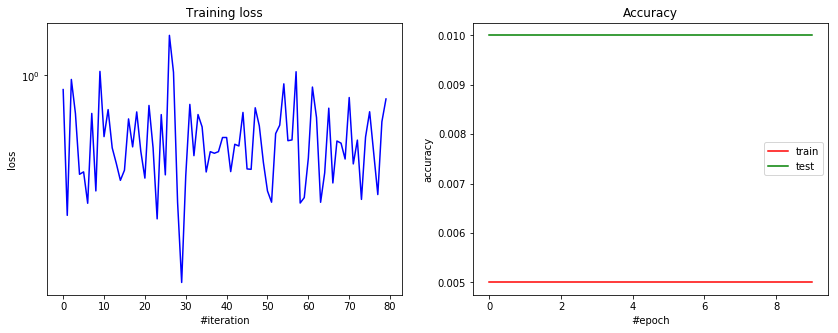

Current loss: 0.994208


In [237]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 10
batch_size = 128

loss_history = train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, sgd_momentum, criterion,
                     optimizer_config, optimizer_state)

### Synthetic data

In [297]:
X_train = X[:int(0.75 * n_samples), :]
y_train = y[:int(0.75 * n_samples)]
X_test = X[int(0.75 * n_samples):, :]
y_test = y[int(0.75 * n_samples):]
print(X_train.shape, X_test.shape)

(600, 50) (200, 50)


In [298]:
net = Sequential()
net.add(Linear(n_features, n_hidden))
net.add(LeakyReLU(slope=0.1))
net.add(Linear(n_hidden, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear(50 -> 40)
LeakyReLU(slope=0.100)
Linear(40 -> 2)
SoftMax



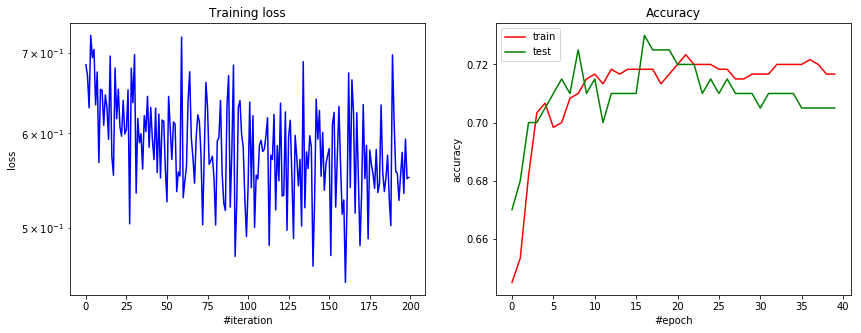

Current loss: 0.551298


In [299]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.05, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 40
batch_size = 128

loss_history = train(net, X_train, y_train, X_test, y_test, batch_size, n_epoch, sgd_momentum, criterion,
                     optimizer_config, optimizer_state, weight_decay=True)

In [300]:
W1 = net.modules[0].W
W2 = net.modules[2].W
b1 = net.modules[0].b
b2 = net.modules[2].b

In [301]:
print(np.sqrt(np.sum(W1 - W1_true) ** 2) / np.sqrt(np.sum(W1_true) ** 2))
print(np.sqrt(np.sum(W2 - W2_true) ** 2) / np.sqrt(np.sum(W2_true) ** 2))

1.28859707121
1.0773631165


### Quadratic programming

In [302]:
def create_opt_problem(X, y, sim, rel, verbose=False):
    """
    % Function generates matrix Q and vector b
    % which represent feature similarities and feature relevances
    %
    % Input:
    % X - [m, n] - design matrix
    % y - [m, 1] - target vector
    % sim - string - indicator of the way to compute feature similarities,
    % support values are 'correl' and 'mi'
    % rel - string - indicator of the way to compute feature significance,
    % support values are 'correl', 'mi' and 'signif'
    %
    % Output:
    % Q - [n ,n] - matrix of features similarities
    % b - [n, 1] - vector of feature relevances
    """
    
    if verbose == True:
        print("Constructing the problem...")
        print('Similarity measure: %s, feature relevance measure: %s' % (sim, rel))
    if len(y.shape) == 1:
        y_mat = y[:, np.newaxis]
    else:
        y_mat = y[:]
        
    cor = np.corrcoef(np.hstack([X, y_mat]).T)
    
    if sim == 'correl':
        Q = cor[:-1, :-1]
    else:
        print("Wrong similarity measure")
        
    if rel == 'correl':
        b = cor[:-1, [-1]]
    elif rel == 'log-reg':
        lr = LogisticRegression()
        b = np.zeros((X.shape[1], 1))
        for i in range(X.shape[1]):
            lr.fit(X[:, [i]], y)
            y_pred = lr.predict(X[:, [i]])
            b[i] = np.corrcoef(y_pred, y)[0, 1]
        b = np.nan_to_num(b)
    else:
        print("Wrong relevance measure")
        
    if verbose == True:
        print("Problem has been constructed.")
    return Q, b


def solve_opt_problem(Q, b, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = cvx.Variable(n)
    
    objective = cvx.Minimize(cvx.quad_form(x, Q) - 1. * b.T * x)
    constraints = [x >= 0, x <= 1]
    prob = cvx.Problem(objective, constraints)
    
    if verbose == True:
        print("Solving the QP problem...")
    
    prob.solve()
    
    if verbose == True:
        print("The problem has been solved!")
        print("Problem status:", prob.status)
        print

    return np.array(x.value).flatten()
    
def quadratic_programming(X, y, sim='correl', rel='correl', verbose=False):
    Q, b = create_opt_problem(X, y, sim, rel, verbose)
    print
    qp_score = solve_opt_problem(Q, b, verbose)
    return qp_score

In [303]:
z = quadratic_programming(X_train, y_train[:, 1], verbose=True)

Constructing the problem...
Similarity measure: correl, feature relevance measure: correl
Problem has been constructed.
Solving the QP problem...
The problem has been solved!
Problem status: optimal


In [304]:
z

array([  3.08212662e-11,   1.02979668e-11,   6.06975495e-11,
         4.68221012e-03,   4.18480963e-11,   2.28247803e-11,
         9.87930297e-12,   1.97199911e-10,   3.25294674e-11,
         3.86621144e-10,   3.33365250e-11,   9.91002256e-12,
         4.35771121e-11,   5.54461479e-11,   1.83729809e-11,
         1.54888543e-11,   8.67808999e-11,   1.10226354e-10,
         7.42640436e-12,   2.87110796e-11,   1.51880624e-10,
         1.34367155e-11,   2.49671721e-11,   1.71820413e-11,
         2.94780489e-11,   2.75130076e-11,   1.18911343e-11,
         2.88263553e-11,   2.87045426e-11,   1.98593912e-11,
         1.18753817e-11,   5.41595560e-11,   7.54845932e-12,
         4.54894073e-11,   5.63017134e-10,   1.85488984e-11,
         1.77670357e-11,   1.81787091e-11,   2.51983929e-11,
         8.08373993e-12,   1.26259562e-11,   3.53647488e-11,
         1.72760894e-11,   1.67934698e-11,   3.13363471e-11,
         1.39381679e-11,   4.21464671e-11,   6.03142048e-12,
         2.52155463e-11,

### Neural Networks QPFS

In [366]:
def create_opt_problem(net):
    W1 = net.modules[0].W
    n_out, n_in = W1.shape
    inp = net.layer_outputs[0]
    out = net.layer_outputs[-1]
    nxt = net.layer_outputs[2]
    corr = np.corrcoef(inp.T)
    Q1 = corr.repeat(n_out, axis=1).repeat(n_out, axis=0)
    
    J = np.zeros([inp.shape[0], n_out * n_in])
    for i, (x_batch, y_batch) in enumerate(get_batches((inp, out), batch_size=1)):
        pred = net.forward(x_batch)
        loss = criterion.forward(pred, y_batch)

        dp = criterion.backward(pred, y_batch)
        net.backward(x_batch, dp)
        J[i, :] = net.modules[0].gradW.ravel('F')
        
    b1 = np.zeros([n_out * n_in, 1])
    for j in range(n_out * n_in):
        b1[j] = np.corrcoef(J[:, j], nxt[:, j % nxt.shape[1]])[0, 1]
    
    return Q1, b1


def solve_opt_problem(Q, b, verbose=False):
    """
     Function solves the quadratic optimization problem stated to select
     significance and noncollinear features

     Input:
     Q - [n, n] - matrix of features similarities
     b - [n, 1] - vector of feature relevances

     Output:
     x - [n, 1] - solution of the quadratic optimization problem
    """
    
    n = Q.shape[0]
    x = cvx.Variable(n)
    
    objective = cvx.Minimize(cvx.quad_form(x, Q) - 100. * b.T * x)
    constraints = [x >= 0, x <= 1]
    prob = cvx.Problem(objective, constraints)
    
    if verbose == True:
        print("Solving the QP problem...")
    
    prob.solve()
    
    if verbose == True:
        print("The problem has been solved!")
        print("Problem status:", prob.status)
        print

    return np.array(x.value).flatten()
    
def quadratic_programming(net, verbose=False):
    Q, b = create_opt_problem(net)
    qp_score = solve_opt_problem(Q, b, verbose)
    return qp_score

In [367]:
net.forward(X_train)
Q1, b1 = create_opt_problem(net)
print(Q1.shape, b1.shape)

(2000, 2000) (2000, 1)


In [368]:
net.forward(X_train)
z = quadratic_programming(net, True)

Solving the QP problem...
The problem has been solved!
Problem status: optimal


In [369]:
for z_ in sorted(z)[::-1][:50]:
    print("{:.7f}".format(z_))

1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
1.0000000
0.8334749
0.7109850
0.6695786
0.6537589
0.5882547
0.5056935
0.3551636
0.2615804
0.2385237
0.0364325
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
0.0000000
